## 优化算法

优化算法的目标函数通常是一个基于训练数据集的损失函数，优化的目标在于降低训练误差。 而深度学习的目标在于降低泛化误差。为了降低泛化误差，除了使用优化算法降低训练误差以外，还需要注意应对过拟合。

在接下来的内容中，我们只关注优化算法在最小化目标函数上的表现，而不关注模型的泛化误差。

深度学习中绝大多数目标函数都很复杂。因此，很多优化问题并不存在解析解，而需要使用基于数值方法的优化算法找到近似解，即数值解。为了求得最小化目标函数的数值解，我们将通过优化算法有限次迭代模型参数来尽可能降低损失函数的值。

其中的两大挑战是**局部最小值**和**鞍点**。

In [3]:
%matplotlib inline
import my_utils
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt

局部最小值示例：

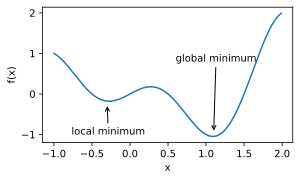

In [75]:
def f(x):
    return x * np.cos(np.pi * x)

my_utils.set_figsize((4.5, 2.5))
x = np.arange(-1., 2., 0.01)
fig, = plt.plot(x, f(x))
fig.axes.annotate('local minimum', xy=(-0.3, -0.25), xytext=(-0.77, -1.), arrowprops=dict(arrowstyle='->'))
fig.axes.annotate('global minimum', xy=(1.1, -0.95), xytext=(0.6, 0.8), arrowprops=dict(arrowstyle='->'))
plt.xlabel('x')
plt.ylabel('f(x)')
plt.savefig('exetreme_p.svg')

鞍点示例：

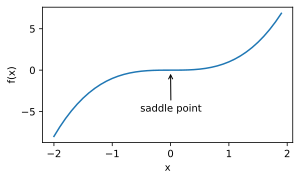

In [76]:
x = np.arange(-2.0, 2.0, 0.1)
fig, = plt.plot(x, x**3)
fig.axes.annotate('saddle point', xy=(0, -0.2), xytext=(-0.52, -5.0),
                  arrowprops=dict(arrowstyle='->'))
plt.xlabel('x')
plt.ylabel('f(x)')
plt.savefig('saddle_p.svg')

三维空间中的鞍点示例：

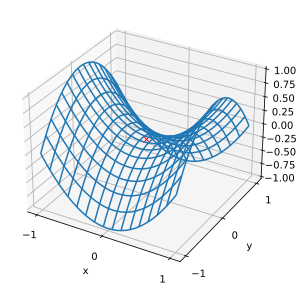

In [77]:
x, y = np.mgrid[-1: 1: 31j, -1: 1: 31j]
z = x**2 - y**2

ax = plt.figure(figsize=(5, 5)).add_subplot(111, projection='3d')
ax.plot_wireframe(x, y, z, **{'rstride': 2, 'cstride': 2})
ax.plot([0], [0], [0], 'rx')
ticks = [-1, 0, 1]
plt.xticks(ticks)
plt.yticks(ticks)
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('saddle2d_p.svg')

在图的鞍点位置，目标函数在$x$轴方向上是局部最小值，但在$y$轴方向上是局部最大值。

假设一个函数的输入为$k$维向量，输出为标量，那么它的海森矩阵（Hessian matrix）有$k$个特征值。该函数在梯度为0的位置上可能是局部最小值、局部最大值或者鞍点。

* 当函数的海森矩阵在梯度为零的位置上的特征值全为正时，该函数得到局部最小值。
* 当函数的海森矩阵在梯度为零的位置上的特征值全为负时，该函数得到局部最大值。
* 当函数的海森矩阵在梯度为零的位置上的特征值有正有负时，该函数得到鞍点。

随机矩阵理论告诉我们，**对于一个大的高斯随机矩阵来说，任一特征值是正或者是负的概率都是0.5**。由于深度学习模型参数通常都是高维的，所以目标函数的鞍点通常比局部最小值更常见。

### 1 梯度下降算法

虽然梯度下降在深度学习中很少被直接使用，但理解梯度的意义以及沿着梯度反方向更新自变量可能降低目标函数值的原因是学习后续优化算法的基础。随后，我们将引出随机梯度下降（stochastic gradient descent）。

#### 1.1 一维梯度下降

设函数$f: \mathbb{R} \rightarrow \mathbb{R}$是一个连续可导的函数，将其在$x$处泰勒展开：

$$
f(x + \epsilon) \approx f(x) + \epsilon f'(x),
$$

其中$\epsilon$是一个很小的数。

选取$\epsilon = -| \eta f'(x) |$，其中$\eta$是一个很小的正常数，则

$$
f \big(x - \eta f'(x) \big) \approx f(x) - \eta f'(x)^2.
$$

若$f'(x) \neq 0$，则

$$
f \big(x - \eta f'(x) \big) \lesssim f(x),
$$

这意味着可以通过

$$
x \leftarrow x - \eta f'(x)
$$

来迭代$x$，从而使得函数值降低。

用$y = x^2$来观察梯度下降法如何工作：

In [19]:
import numpy as np
import torch
import math
import my_utils

In [30]:
def gd(eta):
    # 改写成输入eta和倒数的形式
    x = 10
    results = [x]
    for i in range(10):
        x -= eta * 2 * x
        results.append(x)
    print('epoch 10, x:', x)
    return results

res = gd(0.2)

epoch 10, x: 0.06046617599999997


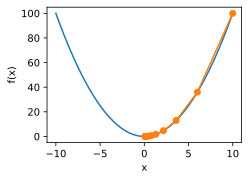

In [31]:
def show_trace(res):
    n = max(abs(min(res)), abs(max(res)), 10)
    f_line = np.arange(-n, n, 0.01)
    my_utils.set_figsize()
    plt.plot(f_line, [x * x for x in f_line])
    plt.plot(res, [x * x for x in res], '-o')
    plt.xlabel('x')
    plt.ylabel('f(x)')

show_trace(res)

学习率对结果的影响：

epoch 10, x: 3.4867844009999995


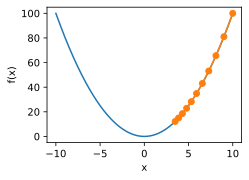

In [32]:
show_trace(gd(0.05))

epoch 10, x: 61.917364224000096


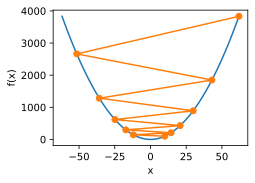

In [33]:
show_trace(gd(1.1))

#### 1.2 多维梯度下降

设$f: \mathbb{R}^d \rightarrow \mathbb{R}$是一个连续可导的函数，则任意点$\vec{x}$上的梯度为

$$
\nabla f(\vec{x}) = \Big[ \frac{\partial f(\vec{x})}{\partial x_1}, ..., \frac{\partial f(\vec{x})}{\partial x_d} \Big]^\top \in \mathbb{R}^{d}.
$$

梯度中每个偏导数$\frac{\partial f(\vec{x})}{\partial x_i}$代表$f$在$\vec{x}$有关输入$x_i$的变化率。定义$f$在$\vec{x}$沿着单位方向$\vec{u}$的方向导数为

$$
D_{\vec{u}} f(\vec{x}) \triangleq \lim_{h \to 0} \frac{f(\vec{x} + h \vec{u}) - f(\vec{x})}{h} 
= \nabla f(\vec{x}) \cdot \vec{u} = \Vert  \nabla f(\vec{x}) \Vert \cdot \cos(\theta),
$$

其中$\theta$为梯度和$\vec{u}$之间的夹角。

方向导数$D_{\vec{u}} f(\vec{x})$给出了$f$在$\vec{x}$上沿着所有可能方向的变量率。当$\theta = \pi$，即$\vec{u}$在梯度方向的反方向时，方向导数$D_{\vec{u}} f(\vec{x})$区最小值，这就是$f$被降低最快的方向。这意味着可以通过

$$
\vec{x} \leftarrow \vec{x} - \eta \nabla f(\vec{x})
$$

来迭代$x$，其中$\eta$时人为添加的学习率。

用$f(\vec{x}) = x_1^2 + 2x_2^2$来观察多维梯度下降如何工作：

In [34]:
def train_2d(trainer):
    x1, x2, s1, s2 = -5, -2, 0, 0
    results = [(x1, x2)]
    for i in range(20):
        x1, x2, s1, s2 = trainer(x1, x2, s1, s2)
        results.append((x1, x2))
    print('epoch %d, x1 %f, x2 %f' % (i + 1, x1, x2))
    return results

def show_trace_2d(f, results):
    plt.plot(*zip(*results), '-o', color='#ff7f0e')
    x1, x2 = np.meshgrid(np.arange(-5.5, 1.0, 0.1), np.arange(-3.0, 1.0, 0.1))
    plt.contour(x1, x2, f(x1, x2), colors='#1f77b4')
    plt.xlabel('x1')
    plt.ylabel('x2')

epoch 20, x1 -0.057646, x2 -0.000073


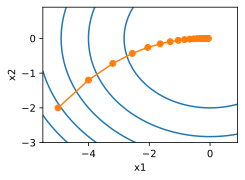

In [39]:
eta = 0.1

def f_2d(x1, x2):  # 目标函数
    return x1 ** 2 + 2 * x2 ** 2

def gd_2d(x1, x2, s1, s2):
    return (x1 - eta * 2 * x1, x2 - eta * 4 * x2, 0, 0)

show_trace_2d(f_2d, train_2d(gd_2d))

#### 1.3 随机梯度下降

设$f_i(\vec{x})$是有关索引为$i$的训练数据样本的损失函数，$n$是训练数据样本数，**$\vec{x}$是模型的参数向量**，那么目标函数定义为

$$
f (\vec{x}) = \frac{1}{n} \sum_{i=1}^n f_i(\vec{x}),
$$

目标在$x$处的梯度计算为

$$
\nabla f (\vec{x}) = \frac{1}{n} \sum_{i=1}^n \nabla f_i(\vec{x}).
$$

在随机梯度下降中，每一轮迭代随机采样一个样本索引$i$来更新模型参数$\vec{x}$：

$$
\vec{x} \leftarrow \vec{x} - \eta \nabla f_i(\vec{x}).
$$

因为$\mathbb{E} \big[\nabla f_i(\vec{x})\big] \approx \frac{1}{n} \sum_{i=1}^n \nabla f_i(\vec{x}) = \nabla f (\vec{x})$，所以随机梯度是对梯度的无偏估计。

在梯度中添加均值为0的随机噪声来模拟随机梯度下降（之所以可以这样做，是因为梯度下降中当前轮的样本来自上一轮的输出，我们只要打破这一点即可模拟不同样本点）：

epoch 20, x1 0.326206, x2 -0.307031


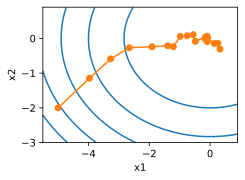

In [40]:
def sgd_2d(x1, x2, s1, s2):
    return (x1 - eta * (2 * x1 + np.random.normal(0.1)),
            x2 - eta * (4 * x2 + np.random.normal(0.1)), 0, 0)

show_trace_2d(f_2d, train_2d(sgd_2d))

随机梯度下降中自变量的迭代轨迹相对于梯度下降中的来说更为曲折。这是由于实验所添加的噪声使模拟的随机梯度的准确度下降。在实际中，这些噪声通常指训练数据集中的无意义的干扰。

### 2 小批量梯度下降算法及其实现

在每一次迭代中，梯度下降使用整个训练数据集来计算梯度，因此它有时也被称为批量梯度下降（batch gradient descent）。如无特别说明，本章节后文的梯度下降均指批量梯度下降。而随机梯度下降在每次迭代中只随机采样一个样本来计算梯度。我们还可以在每轮迭代中随机均匀采样多个样本来组成一个小批量，然后使用这个小批量来计算梯度，这就是小批量梯度下降（mini-batch gradient descent）。

设目标函数$f(\vec{x}): \mathbb{R}^d \to \mathbb{R}$，其中$\vec{x}$为待学习的参数。在迭代开始前的时间步设为0。该时间步的自变量记为$\vec{x}_0$，通常由随机初始化得到。在接下来的每一个时间步$t > 0$中，小批量随机梯度下降随机均匀采样一个由训练数据样本索引组成的小批量$\mathcal{B}_t$。我们可以通过重复采样（sampling with replacement）或者不重复采样（sampling without replacement）得到一个小批量中的各个样本。前者允许同一个小批量中出现重复的样本，后者则不允许如此，且更常见。对于这两者间的任一种方式，都可以使用

$$
\vec{g}_t \leftarrow \nabla f_{\mathcal{B}_t} (\vec{x}_{t-1}) = 
\frac{1}{|\mathcal{B}_t|} \sum_{i \in \mathcal{B}_t} \nabla f_i (\vec{x}_{t-1})
$$

来计算时间步$t$的小批量$\mathcal{B}_t|$上目标函数位于$\vec{x}_{t-1}$处的梯度$\vec{g}_t$。这里$\mathcal{B}_t$代表小批量中样本的个数，是一个超参数。$\vec{g}_t$是对$\nabla f (\vec{x}_{t-1})$的无偏估计。给定学习率$\eta_t > 0$，小批量随机梯度下降对自变量的迭代如下：

$$
\vec{x}_t \leftarrow \vec{x}_{t-1} - \eta_t \vec{g}_t.
$$

**为什么小批量梯度下降需要衰减学习率？**

因为基于随机采样得到的梯度的方差在迭代过程中无法减小，在逼近局部极小值点时不可避免会震荡。相比之下，梯度下降（bgd）则不需要衰减学习率。这是因为梯度下降中的$\vec{g}_t$就是目标函数的真实梯度，而非无偏估计的结果。

#### 2.1 从零开始实现
使用一个来自NASA的测试不同飞机机翼噪音的数据集来比较各个优化算法。我们使用该数据集的前1,500个样本和5个特征，并使用标准化对数据进行预处理。

In [42]:
%matplotlib inline
import numpy as np
import time
import torch
from torch import nn, optim
import my_utils

def get_NASA_data():
    data = np.genfromtxt('../data/airfoil_self_noise.dat', delimiter='\t')
    data = (data - data.mean(axis=0)) / data.std(axis=0)
    # 前1500个样本(每个样本5个特征)
    return torch.tensor(data[:1500, :-1], dtype=torch.float32), torch.tensor(data[:1500, -1], dtype=torch.float32)

features, labels = get_NASA_data()
features.shape

torch.Size([1500, 5])

重新实现小批量梯度下降算法：添加了一个状态输入states并将超参数放在字典hyperparams里。此外，我们将在训练函数里对各个小批量样本的损失求平均，因此优化算法里的梯度不需要除以批量大小。

In [43]:
def sgd(params, states, hyperparams):
    for p in params:
        p.data -= hyperparams['lr'] * p.grad.data

下面实现一个通用的训练函数，以方便本章后面介绍的其他优化算法使用。它初始化一个线性回归模型，然后可以使用小批量随机梯度下降以及后续小节介绍的其他算法来训练模型。

In [64]:
def opt_train(optimizer_fn, states,  hyperparams, features, labels, batch_size=10, num_epochs=2):
    net, loss = my_utils.linreg, my_utils.squared_loss
    w = torch.nn.Parameter(
        torch.tensor(np.random.normal(0, 0.01, size=(features.shape[1], 1)), dtype=torch.float32),
        requires_grad=True
    )
    b = torch.nn.Parameter(torch.zeros(1, dtype=torch.float32), requires_grad=True)
    
    def eval_loss():
        return loss(net(features, w, b), labels).mean().item()
    
    ls = [eval_loss()]
    data_iter = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(features, labels), batch_size, shuffle=True)
    
    for _ in range(num_epochs):
        start = time.time()
        for batch_i, (X, y) in enumerate(data_iter):
            l = loss(net(X, w, b), y).mean()  # 使用平均损失

            # 梯度清零
            if w.grad is not None:
                w.grad.data.zero_()
                b.grad.data.zero_()

            l.backward()
            optimizer_fn([w, b], states, hyperparams)  # 迭代模型参数
            if (batch_i + 1) * batch_size % 100 == 0:
                ls.append(eval_loss())  # 每100个样本记录下当前训练误差
    
    # 打印结果和作图
    print('loss: %f, %f sec per epoch' % (ls[-1], time.time() - start))
    my_utils.set_figsize()
    plt.plot(np.linspace(0, num_epochs, len(ls)), ls)
    plt.xlabel('epoch')
    plt.ylabel('loss')

测试梯度下降：

loss: 0.247856, 0.014713 sec per epoch


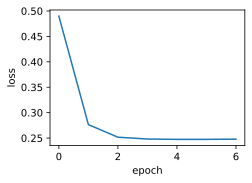

In [65]:
def train_sgd(lr, batch_size, num_epochs=2):
    opt_train(sgd, None, {'lr': lr}, features, labels, batch_size, num_epochs)

train_sgd(1, 1500, 6)

测试随机梯度下降：

loss: 0.242072, 0.356553 sec per epoch


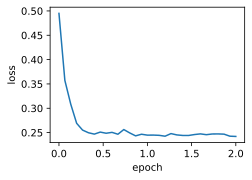

In [66]:
train_sgd(0.005, 1)

测试小批量梯度下降：

loss: 0.243443, 0.053297 sec per epoch


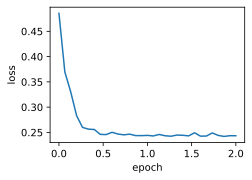

In [67]:
train_sgd(0.05, 10)

#### 2.2 简洁实现

通过创建optimizer实例来调用优化算法。

In [73]:
def opt_train_torch(optimizer_fn, optimizer_hyperparams, features, labels, batch_size=10, num_epochs=2):
    # 初始化模型
    net = nn.Sequential(
        nn.Linear(features.shape[-1], 1)
    )
    loss = nn.MSELoss()
    optimizer = optimizer_fn(net.parameters(), **optimizer_hyperparams)
    
    def eval_loss():
        # 除以2是为了和opt_train()保持一致, 因为squared_loss中除了2
        return loss(net(features).view(-1), labels).item() / 2
    
    ls = [eval_loss()]
    data_iter = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(features, labels), batch_size, shuffle=True)

    for _ in range(num_epochs):
        start = time.time()
        for batch_i, (X, y) in enumerate(data_iter):
            l = loss(net(X).view(-1), y) / 2 

            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            if (batch_i + 1) * batch_size % 100 == 0:
                ls.append(eval_loss())
    # 打印结果和作图
    print('loss: %f, %f sec per epoch' % (ls[-1], time.time() - start))
    my_utils.set_figsize()
    plt.plot(np.linspace(0, num_epochs, len(ls)), ls)
    plt.xlabel('epoch')
    plt.ylabel('loss')

测试小批量梯度下降：

loss: 0.244153, 0.059348 sec per epoch


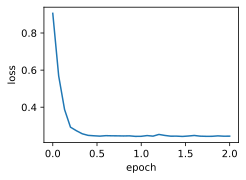

In [74]:
opt_train_torch(optim.SGD, {'lr': 0.05}, features, labels, 10)